In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from scripts.insar_conversion import convert_insar_to_u
import numpy as np

### Import mining region

In [3]:
# --- Read shapefile ---
shp_area = r"maps\concessions_SL\Concessions_SL_area_v1.shp"
gdf_area = gpd.read_file(shp_area)

# Ensure shapefile is in lat/lon
gdf_area = gdf_area.to_crs(epsg=4326)

### Import GNSS

In [4]:
# --- Load ---
path = "gnss/gnss_data.csv"
df = pd.read_csv(path)

# --- Parse + clean ---
df["dates"] = pd.to_datetime(df["dates"], errors="coerce")
df = df.dropna(subset=["dates"])  # drop rows with bad dates

In [5]:
df.head()

,pnt_id,pnt_name,pnt_lat,pnt_lon,pnt_xrd,pnt_yrd,dates,n,e,u,sn,se,su
0,0591,Aachen,50.767778,6.088333,204465.62255,308885.632138,2002-11-20,0.000426,0.007671,0.005879,0.000932,0.000673,0.002627
1,0591,Aachen,50.767778,6.088333,204465.62255,308885.632138,2007-11-12,0.000447,-0.001009,-0.005334,0.000888,0.000654,0.002506
2,0591,Aachen,50.767778,6.088333,204465.62255,308885.632138,2007-11-11,0.000381,0.000116,-0.005035,0.000889,0.000652,0.002511
3,0591,Aachen,50.767778,6.088333,204465.62255,308885.632138,2007-11-10,0.000678,-0.001208,-0.006365,0.000893,0.000657,0.002522
4,0591,Aachen,50.767778,6.088333,204465.62255,308885.632138,2007-11-09,-0.000864,-0.002044,-0.009819,0.000904,0.000663,0.002558


### Import InSAR

In [6]:
loc_asc = r'insar/sentinel1_asc_t088_limburg.csv'
loc_dsc = r'insar/sentinel1_dsc_t037_limburg.csv'

insar_asc_LOS = pd.read_csv(loc_asc, sep=',')
insar_dsc_LOS = pd.read_csv(loc_dsc, sep=',')

In [7]:
insar_asc_u = convert_insar_to_u(insar_asc_LOS)
insar_dsc_u = convert_insar_to_u(insar_dsc_LOS)

In [8]:
# # Extract the dates from the .csv file
dates = pd.to_datetime(insar_asc_u.filter(regex='^u_20').columns, format='u_%Y%m%d')

# # Extract the displacement data from the .csv file
disp_asc_u = insar_asc_u.filter(regex='^u_20')
disp_asc_d = insar_asc_LOS.filter(regex='^d_20')

# Calculate the nr of days between the observations where the first observations is day 0
days = (dates- dates[0]).days
years = days/365

### Plot all data

C:\Users\Nigel\AppData\Local\Temp\ipykernel_11044\2784325883.py:52: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


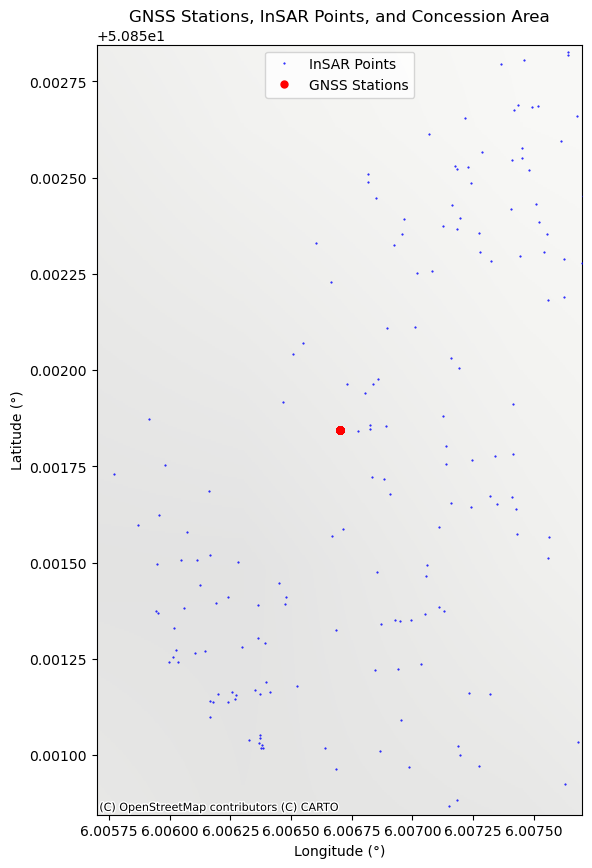

In [21]:
# --- Create figure ---
fig, ax = plt.subplots(figsize=(10, 10))

# --- Plot concession area ---
gdf_area.plot(
    ax=ax,
    edgecolor="black",
    facecolor="none",
    linewidth=1.5,
    zorder=2,
    label="Concession Area"
)

# --- Plot InSAR points ---
ax.plot(
    insar_asc_u.pnt_lon,
    insar_asc_u.pnt_lat,
    ".",
    color="blue",
    markersize=1,
    alpha=1,
    label="InSAR Points",
    zorder=3
)

# --- Plot GNSS stations ---
ax.plot(
    df["pnt_lon"],
    df["pnt_lat"],
    "o",
    color="red",
    markersize=5,
    label="GNSS Stations",
    zorder=4
)

# --- Add GNSS station labels ---
# for name in df["pnt_name"].unique():
#     subset = df[df["pnt_name"] == name]
#     ax.text(
#         subset["pnt_lon"].iloc[0],
#         subset["pnt_lat"].iloc[0],
#         name,
#         fontsize=8,
#         zorder=5
#     )

# --- Labels & title ---
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
ax.set_title("GNSS Stations, InSAR Points, and Concession Area")
ax.legend()

station_name = "Kerkrade"
buffer = 0.001

st = df.loc[df["pnt_name"] == station_name].iloc[0]
x0, y0 = st["pnt_lon"], st["pnt_lat"]

xmin, xmax = x0 - buffer, x0 + buffer
ymin, ymax = y0 - buffer, y0 + buffer

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)


#label only stations inside current view
# df_view = df[(df["pnt_lon"].between(xmin, xmax)) & (df["pnt_lat"].between(ymin, ymax))]

# for name in df_view["pnt_name"].unique():
#     s = df_view[df_view["pnt_name"] == name].iloc[0]
#     ax.text(s["pnt_lon"], s["pnt_lat"], name, fontsize=8, zorder=10, clip_on=True)

#--- Add basemap (NO API KEY REQUIRED) ---
ctx.add_basemap(
    ax,
    crs="EPSG:4326",
    source=ctx.providers.CartoDB.Positron,
    zoom=10
)

plt.show()


In [16]:
def haversine_m(lat1, lon1, lat2, lon2):
    """
    Great-circle distance between (lat1, lon1) and (lat2, lon2) in meters.
    Inputs can be scalars or numpy arrays.
    """
    R = 6371000.0  # Earth radius [m]
    lat1 = np.deg2rad(lat1); lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2); lon2 = np.deg2rad(lon2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def find_nearest_insar_points(insar_df, lat_0, lon_0, N=5,
                              lat_col="pnt_lat", lon_col="pnt_lon"):
    """
    Returns the N nearest InSAR points to (lat_0, lon_0) with distances in meters.
    """
    lat = insar_df[lat_col].to_numpy()
    lon = insar_df[lon_col].to_numpy()

    dist_m = haversine_m(lat_0, lon_0, lat, lon)
    nearest_idx = np.argsort(dist_m)[:N]

    out = insar_df.iloc[nearest_idx].copy()
    out["dist_m"] = dist_m[nearest_idx]
    return out.sort_values("dist_m")




In [17]:
station_name = 'Kerkrade'
lat_0 = df.loc[df['pnt_name'] == station_name, 'pnt_lat'].values[0]
lon_0 = df.loc[df['pnt_name'] == station_name, 'pnt_lon'].values[0]

print(f"{station_name} coordinates: lat={lat_0}, lon={lon_0}")


N = 5

# Use the DataFrame that still has metadata columns (pnt_lat/pnt_lon) + u_ columns.
# For example: insar_asc_u = add_vertical_insar(insar_asc) or convert_insar_to_u(insar_asc_LOS)
nearest = find_nearest_insar_points(insar_asc_u, lat_0, lon_0, N=N)

display(nearest[["pnt_id", "pnt_lat", "pnt_lon", "dist_m"]].head(N))

print(len(nearest))

Kerkrade coordinates: lat=50.851845, lon=6.0067


,pnt_id,pnt_lat,pnt_lon,dist_m
52106,L00012592P00029966,50.851842,6.006776,5.318895
52107,L00012592P00029967,50.851847,6.006823,8.672079
52105,L00012592P00029965,50.851858,6.006824,8.840901
52620,L00012593P00029967,50.851940,6.006803,12.815405
52619,L00012593P00029966,50.851964,6.006731,13.381351


5


In [18]:
import matplotlib.pyplot as plt

def plot_gnss_insar_locations(insar_df, nearest_df, lat_0, lon_0,
                              lat_col="pnt_lat", lon_col="pnt_lon"):
    """
    Plot GNSS location and nearest InSAR points in lon-lat space.
    """
    plt.figure(figsize=(6, 6))

    # Nearest InSAR points
    plt.scatter(
        nearest_df[lon_col],
        nearest_df[lat_col],
        s=80,
        c="tab:blue",
        marker="o",
        label="Nearest InSAR points"
    )

    # GNSS station
    plt.scatter(
        lon_0,
        lat_0,
        s=120,
        c="red",
        marker="*",
        label="GNSS station"
    )

    # Annotate distances (optional but useful)
    for _, row in nearest_df.iterrows():
        plt.text(
            row[lon_col],
            row[lat_col],
            f"{row['dist_m']:.0f} m",
            fontsize=8,
            ha="left",
            va="bottom"
        )

    plt.xlabel("Longitude [deg]")
    plt.ylabel("Latitude [deg]")
    plt.title("GNSS station and nearest InSAR points")
    plt.axis("equal")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


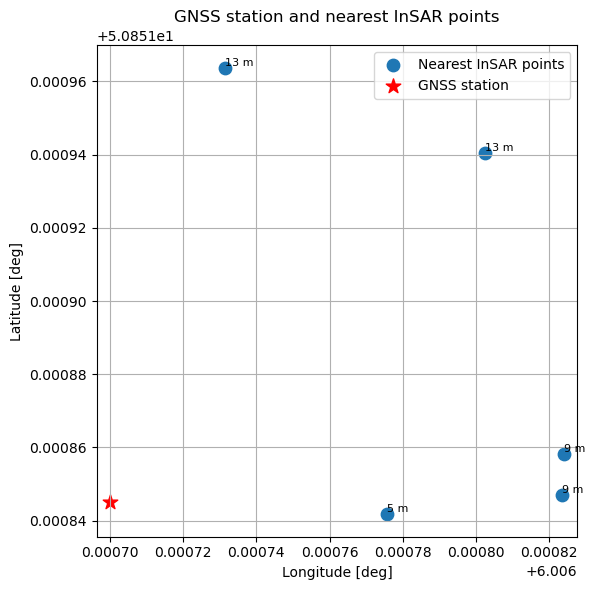

In [19]:
plot_gnss_insar_locations(
    insar_df=insar_asc_u,   # full InSAR DF with lat/lon
    nearest_df=nearest,     # output from find_nearest_insar_points
    lat_0=lat_0,
    lon_0=lon_0
)


In [ ]:
# Extract displacement time series for nearest InSAR points
u_cols = insar_asc_u.filter(regex=r"^u_20").columns
disp_nearest_u = insar_asc_u.loc[nearest.index, u_cols]  # shape (N, n_times)

insar_mean_u = disp_nearest_u.mean(axis=0)  # Series indexed by u_YYYYMMDD columns

dates = pd.to_datetime(u_cols, format="u_%Y%m%d")


C:\Users\Nigel\AppData\Local\Temp\ipykernel_11044\2475797792.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


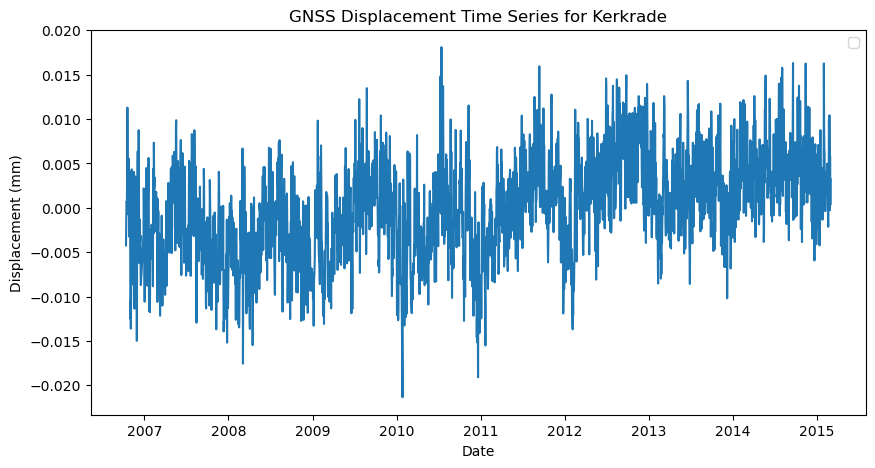

In [29]:
# Kerrade time series

series_kerkrade = df[df["pnt_name"] == station_name].copy()
series_kerkrade_sorted = series_kerkrade.sort_values(by="dates")

plt.figure(figsize=(10, 5))
plt.plot(series_kerkrade_sorted["dates"], series_kerkrade_sorted["u"])
plt.xlabel("Date")
plt.ylabel("Displacement (mm)")
plt.title(f"GNSS Displacement Time Series for {station_name}")
plt.legend()
plt.show()

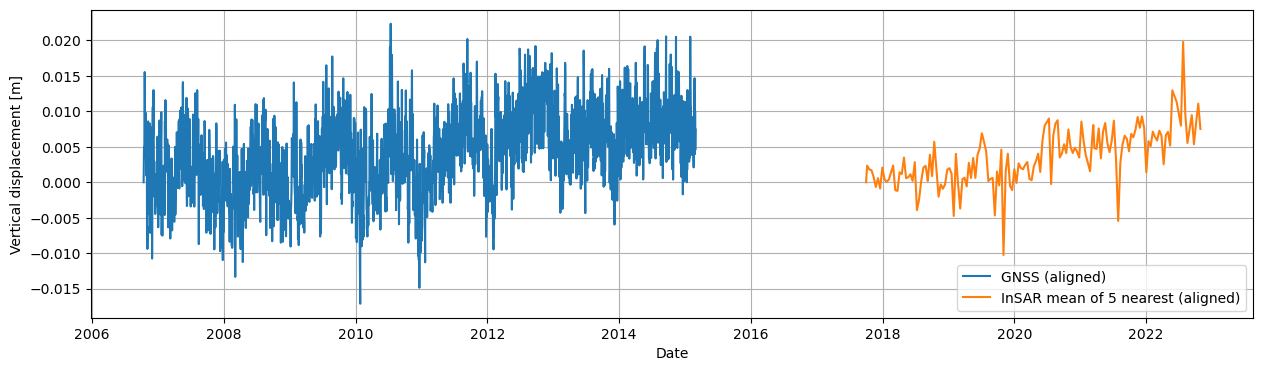

In [31]:
import matplotlib.pyplot as plt

# Convert InSAR mean to numpy aligned with dates
insar_u_vals = insar_mean_u.to_numpy()

# Simple reference shift: align first value (you can also align over overlapping window)
insar_u_vals_aligned = insar_u_vals - insar_u_vals[0]
gnss_u_aligned = series_kerkrade_sorted["u"] - series_kerkrade_sorted["u"].iloc[0]

plt.figure(figsize=(15,4))
plt.plot(series_kerkrade_sorted["dates"], gnss_u_aligned, label="GNSS (aligned)")
plt.plot(dates, insar_u_vals_aligned, label=f"InSAR mean of {N} nearest (aligned)")
plt.xlabel("Date")
plt.ylabel("Vertical displacement [m]")
plt.grid(True)
plt.legend()
plt.show()


# Ideas to continue

- Check the sign of the InSAR data
- Take the distance from the station into account in weighted technique
- Linear or model fit to the GNSS data
  - Constant model: $u_{GNSS} \approx u_{InSAR} + c$ and estimate c as the median of differences
  - Linear trend model: $u_{GNSS} \approx a + bt + u_{InSAR}$
  - Seasonal model : $u_{GNSS} \approx a + bt Asin(2pit) + Bcos(2pit) + \epsilon$ then evaluate model at InSAR dates and estimate only on offset
- Data does not overlap
  - Option 1: Use the trend of the GNSS but is risky but OK for this assignment
  - Option 2: Make use of other GNSS stations that do have overlap



Assignment overall:
Part 1: Data integration
- Conversion of InSAR LOS to 'u'
- Datum alignment of the InSAR points using GNSS (working on this now)

Part 2: Anomaly detection
- Time-series modelling to get the acceleration
- Define anomalies
- Find anomalies